In [1]:
######################################################################
# copy-paste of: https://keras.io/examples/rl/deep_q_network_breakout/
# With some modifications to make it work for pods...

import tensorflow as tf
import numpy as np
from pod.ai.ai_utils import THRUST_VALUES, ANGLE_VALUES, state_to_vector, action_to_output, MAX_VEL
from pod.ai.ai_utils import reward as reward_func
from pod.game import game_step
from pod.board import PodBoard
from vec2 import Vec2
from pod.util import PodState

board = PodBoard([Vec2(5000, 4000), Vec2(12000, 7000)])

In [5]:
# Configuration paramaters for the whole setup
seed = 42
gamma = 0.99  # Discount factor for past rewards
epsilon = 1.0  # Epsilon greedy parameter
epsilon_min = 0.1  # Minimum epsilon greedy parameter
epsilon_max = 1.0  # Maximum epsilon greedy parameter
epsilon_interval = (
    epsilon_max - epsilon_min
)  # Rate at which to reduce chance of random action being taken
batch_size = 32  # Size of batch taken from replay buffer
max_steps_per_episode = 40


num_actions = THRUST_VALUES * ANGLE_VALUES


def create_q_model():
    return tf.keras.Sequential([
        tf.keras.layers.Dense(
            24,
            input_shape=(6,),
            activation="tanh"
        ),
        tf.keras.layers.Dense(
            THRUST_VALUES * ANGLE_VALUES
        )
    ])


# The first model makes the predictions for Q-values which are used to
# make a action.
model = create_q_model()
# Build a target model for the prediction of future rewards.
# The weights of a target model get updated every (update_target_network) steps thus when the
# loss between the Q-values is calculated the target Q-value is stable.
model_target = create_q_model()

In [6]:
# In the Deepmind paper they use RMSProp however then Adam optimizer
# improves training time
optimizer = tf.optimizers.Adam(learning_rate=0.001)

# Experience replay buffers
action_history = []
state_history = []
state_next_history = []
rewards_history = []
done_history = []
episode_reward_history = []
running_reward = 0
episode_count = 0
frame_count = 0
# Number of frames to take random action and observe output
epsilon_random_frames = 20000
# Number of frames for exploration
epsilon_greedy_frames = 20000.0
# Maximum replay length
# Note: The Deepmind paper suggests 1000000 however this causes memory issues
max_memory_length = 100000
# Train the model after 4 actions
update_after_actions = 4
# How often to update the target network
update_target_network = 1000
# Using huber loss for stability
loss_function = tf.losses.Huber()

def pod_to_state(p):
    return state_to_vector(
        p.pos,
        p.vel,
        p.angle,
        board.get_check(p.nextCheckId),
        board.get_check(p.nextCheckId + 1))

pod = PodState()
pod_next = PodState()

In [7]:
while True:  # Run until solved
    pod = PodState()
    state = pod_to_state(pod)
    episode_reward = 0
    random_action_count = 0
    total_action_count = 0

    for timestep in range(1, max_steps_per_episode):
        # env.render(); Adding this line would show the attempts
        # of the agent in a pop up window.
        frame_count += 1

        # Use epsilon-greedy for exploration
        if frame_count < epsilon_random_frames or epsilon > np.random.rand(1)[0]:
            # Take random action
            random_action_count += 1
            action = np.random.choice(num_actions)
        else:
            # Predict action Q-values
            # From environment state
            state_tensor = tf.convert_to_tensor(state)
            state_tensor = tf.expand_dims(state_tensor, 0)
            action_probs = model(state_tensor, training=False)
            # Take best action
            action = tf.argmax(action_probs[0]).numpy()
        
        # Decay probability of taking random action
        if frame_count > epsilon_random_frames:
            epsilon -= epsilon_interval / epsilon_greedy_frames
            epsilon = max(epsilon, epsilon_min)

        total_action_count += 1
        
        # Apply the sampled action in our environment
        game_step(board, pod, action_to_output(action, pod.angle, pod.pos), pod_next)
        state_next = pod_to_state(pod_next)
        reward = reward_func(pod_next, board)
        done = pod_next.turns >= max_steps_per_episode

        state_next = np.array(state_next)

        episode_reward += reward

        # Save actions and states in replay buffer
        action_history.append(action)
        state_history.append(state)
        state_next_history.append(state_next)
        done_history.append(done)
        rewards_history.append(reward)
        state = state_next

        # Update every fourth frame and once batch size is over 32
        if frame_count % update_after_actions == 0 and len(done_history) > batch_size:
            # Get indices of samples for replay buffers
            indices = np.random.choice(range(len(done_history)), size=batch_size)

            # Using list comprehension to sample from replay buffer
            state_sample = np.array([state_history[i] for i in indices])
            state_next_sample = np.array([state_next_history[i] for i in indices])
            rewards_sample = [rewards_history[i] for i in indices]
            action_sample = [action_history[i] for i in indices]
            done_sample = tf.convert_to_tensor(
                [float(done_history[i]) for i in indices]
            )

            # Build the updated Q-values for the sampled future states
            # Use the target model for stability
            future_rewards = model_target.predict(state_next_sample)
            # Q value = reward + discount factor * expected future reward
            updated_q_values = rewards_sample + gamma * tf.reduce_max(
                future_rewards, axis=1
            )

            # If final frame set the last value to -1
            updated_q_values = updated_q_values * (1 - done_sample) - done_sample

            # Create a mask so we only calculate loss on the updated Q-values
            masks = tf.one_hot(action_sample, num_actions)

            with tf.GradientTape() as tape:
                # Train the model on the states and updated Q-values
                q_values = model(state_sample)

                # Apply the masks to the Q-values to get the Q-value for action taken
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
                # Calculate loss between new Q-value and old Q-value
                loss = loss_function(updated_q_values, q_action)

            # Backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        if frame_count % update_target_network == 0:
            # update the the target network with new weights
            model_target.set_weights(model.get_weights())
            # Log details
            template = "running reward: {:.2f} at episode {}, frame count {}"
            print(template.format(running_reward, episode_count, frame_count))
            print("   random actions: {} / {} epsilon: {}".format(random_action_count, total_action_count, epsilon))

        # Limit the state and reward history
        if len(rewards_history) > max_memory_length:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del done_history[:1]

        if done:
            break

    # Update running reward to check condition for solving
#    print("Reward for episode {}: {} frames {} epsilon {}".format(episode_count, episode_reward, frame_count, epsilon))
    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)

    episode_count += 1

    if running_reward > 60:  # Condition to consider the task solved
        print("Solved at episode {}!".format(episode_count))
        break

    if frame_count > 50000:
        print("Giving up after {} frames".format(frame_count))
        break


running reward: 56.07 at episode 25, frame count 1000
   random actions: 25 / 25 epsilon: 1.0
running reward: 56.06 at episode 51, frame count 2000
   random actions: 11 / 11 epsilon: 1.0
running reward: 56.06 at episode 76, frame count 3000
   random actions: 36 / 36 epsilon: 1.0
running reward: 56.06 at episode 102, frame count 4000
   random actions: 22 / 22 epsilon: 1.0
running reward: 56.06 at episode 128, frame count 5000
   random actions: 8 / 8 epsilon: 1.0
running reward: 56.06 at episode 153, frame count 6000
   random actions: 33 / 33 epsilon: 1.0
running reward: 56.06 at episode 179, frame count 7000
   random actions: 19 / 19 epsilon: 1.0
running reward: 56.06 at episode 205, frame count 8000
   random actions: 5 / 5 epsilon: 1.0
running reward: 56.06 at episode 230, frame count 9000
   random actions: 30 / 30 epsilon: 1.0
running reward: 56.05 at episode 256, frame count 10000
   random actions: 16 / 16 epsilon: 1.0
running reward: 56.06 at episode 282, frame count 11000


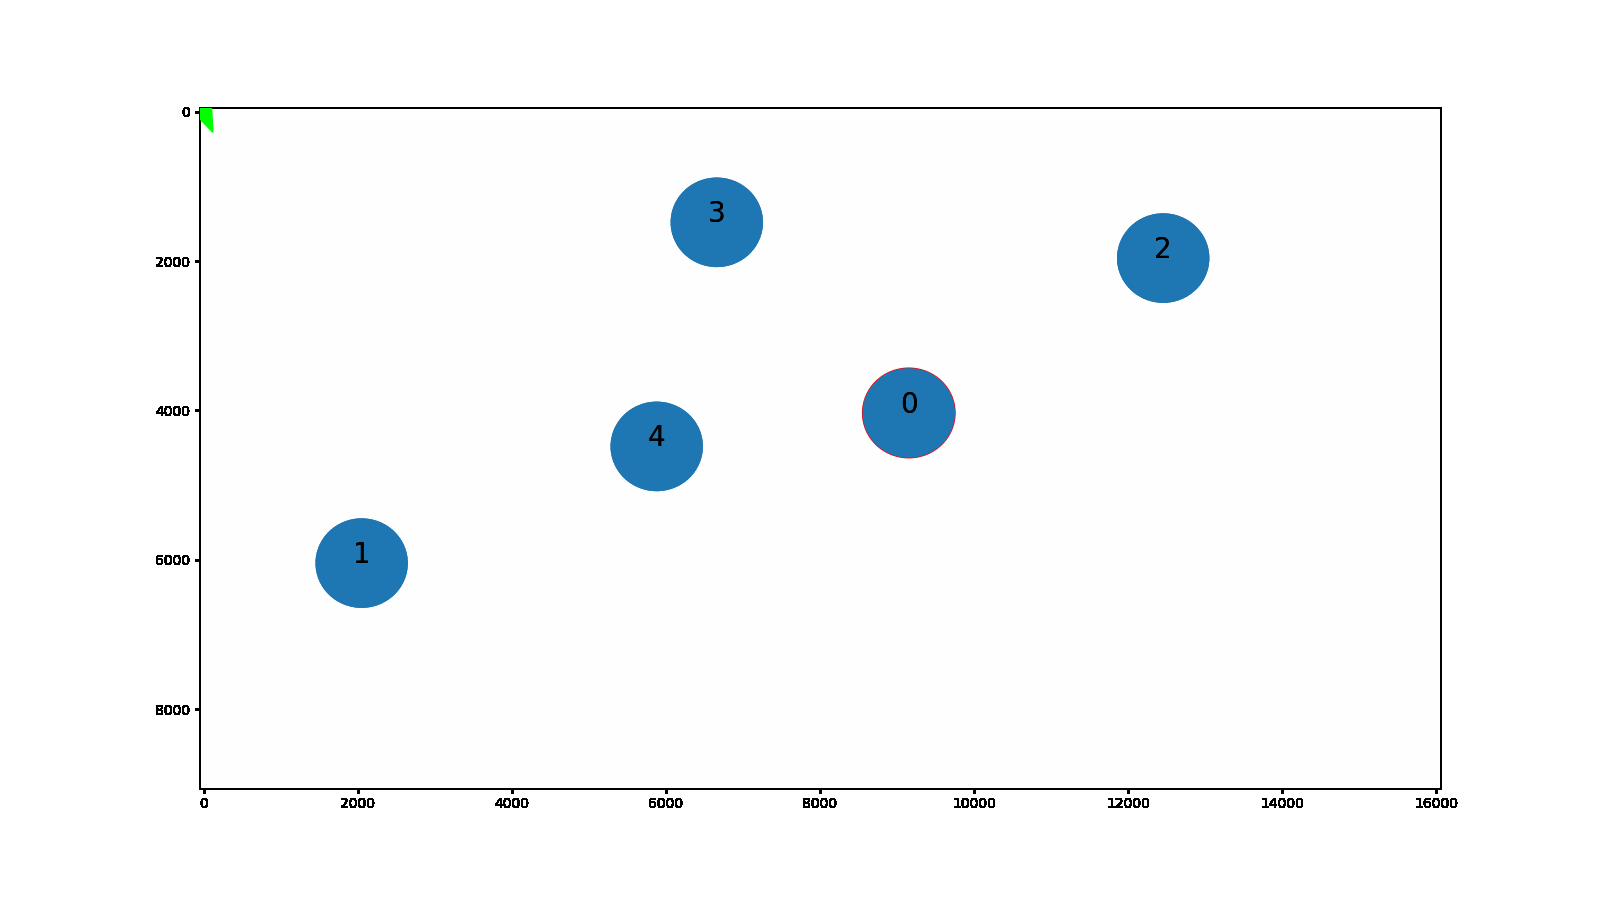

In [10]:
from pod.ai.manual import DQController
from pod.game import Player
from pod.drawer import Drawer
from IPython.display import Image

test_board = PodBoard()
controller = DQController(test_board)
controller.model = model_target

player = Player(controller)
player.pod.angle = 1.23
drawer = Drawer(test_board, [player])

file = '/tf/notebooks/pods.gif'
drawer.animate(file, 50)
Image(filename = file)